# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report

# Load Data

In [2]:
# Load feature-selected dataset (from Phase 2.3)
df_selected = pd.read_csv("data/heart_disease_selected.csv")

label_col = "target"
X = df_selected.drop(columns=[label_col])
y = df_selected[label_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

"Train shape:", X_train.shape, " Test shape:", X_test.shape

('Train shape:', (242, 16), ' Test shape:', (61, 16))

# Train Models and Evaluation

In [3]:
#@title Function to Evaluate the models

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"============ {model_name} ============")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {auc:.3f}" if auc else "AUC: N/A")

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "AUC": auc
    }


## Logistic Regression

In [4]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
results_logreg = evaluate_model(log_reg, X_train, y_train, X_test, y_test, "Logistic Regression")

============ Logistic Regression ============
              precision    recall  f1-score   support

           0       0.96      0.82      0.89        33
           1       0.82      0.96      0.89        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.90      0.89      0.89        61

AUC: 0.958


## Decision Tree

In [5]:
dt = DecisionTreeClassifier(random_state=42)
results_dt = evaluate_model(dt, X_train, y_train, X_test, y_test, "Decision Tree")

============ Decision Tree ============
              precision    recall  f1-score   support

           0       0.79      0.67      0.72        33
           1       0.67      0.79      0.72        28

    accuracy                           0.72        61
   macro avg       0.73      0.73      0.72        61
weighted avg       0.73      0.72      0.72        61

AUC: 0.726


# Random Forest

In [6]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
results_rf = evaluate_model(rf, X_train, y_train, X_test, y_test, "Random Forest")

============ Random Forest ============
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61

AUC: 0.944


## Support Vector Machine

In [7]:
svm = SVC(kernel="rbf", probability=True, random_state=42)
results_svm = evaluate_model(svm, X_train, y_train, X_test, y_test, "SVM (RBF)")

============ SVM (RBF) ============
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        33
           1       0.90      0.96      0.93        28

    accuracy                           0.93        61
   macro avg       0.93      0.94      0.93        61
weighted avg       0.94      0.93      0.93        61

AUC: 0.958


In [8]:
results_df = pd.DataFrame([results_logreg, results_dt, results_rf, results_svm])
results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,Logistic Regression,0.885246,0.818182,0.964286,0.885246,0.957792
1,Decision Tree,0.721311,0.666667,0.785714,0.721311,0.726190
2,Random Forest,0.868852,0.812500,0.928571,0.866667,0.943723
3,SVM (RBF),0.934426,0.900000,0.964286,0.931034,0.957792


# Comparing Models

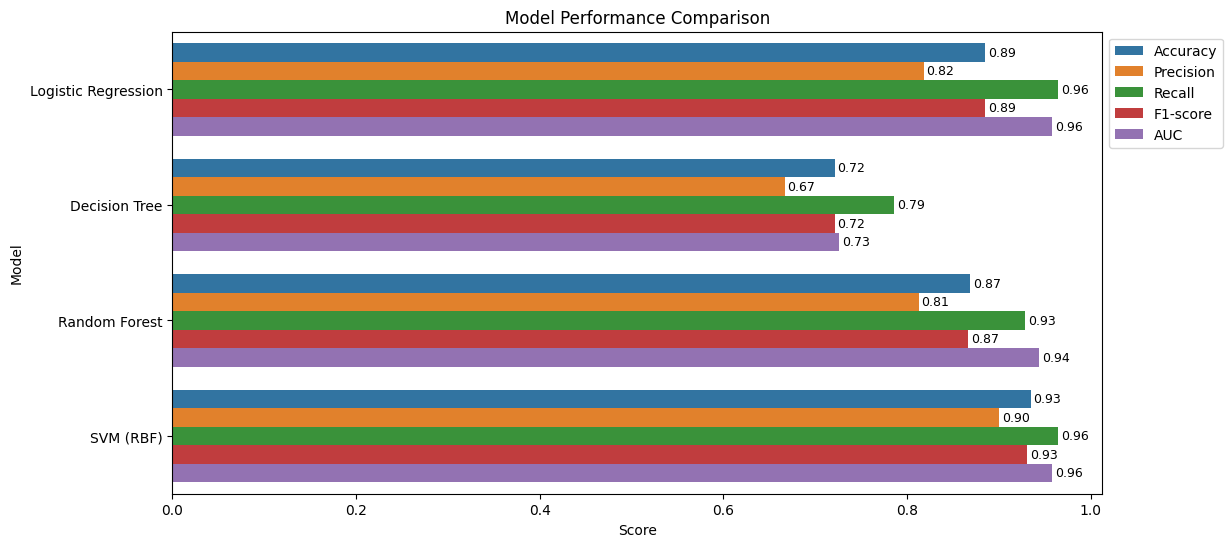

In [9]:
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=results_df.melt(id_vars="Model",
                         value_vars=["Accuracy","Precision","Recall","F1-score","AUC"]),
    x="value", y="Model", hue="variable"
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", fontsize=9, label_type="edge", padding=2)

plt.title("Model Performance Comparison")
plt.xlabel("Score")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


# ROC Curves (Receiver Operating Characteristic curve)

> A graph that shows the performance of a binary classification model across different thresholds by plotting the true positive rate (sensitivity) against the false positive rate (1-specificity). It is used to evaluate diagnostic tests and machine learning models by visualizing their ability to discriminate between two groups, with the area under the curve (AUC) providing a single measure of overall performance

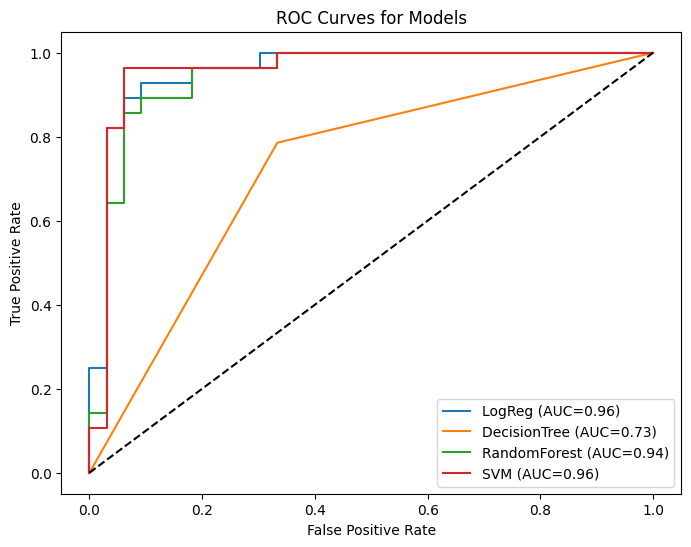

In [10]:
plt.figure(figsize=(8,6))

models = {
    "LogReg": log_reg,
    "DecisionTree": dt,
    "RandomForest": rf,
    "SVM": svm
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models")
plt.legend()
plt.show()

# Thanks